[*********************100%***********************]  1 of 1 completed


Historical Drift (Annualized Mean Return): 0.1344
GBM Drift (Expected Growth Rate): 0.0970
Historical Volatility: 0.2734
Simulated Volatility: 0.3173


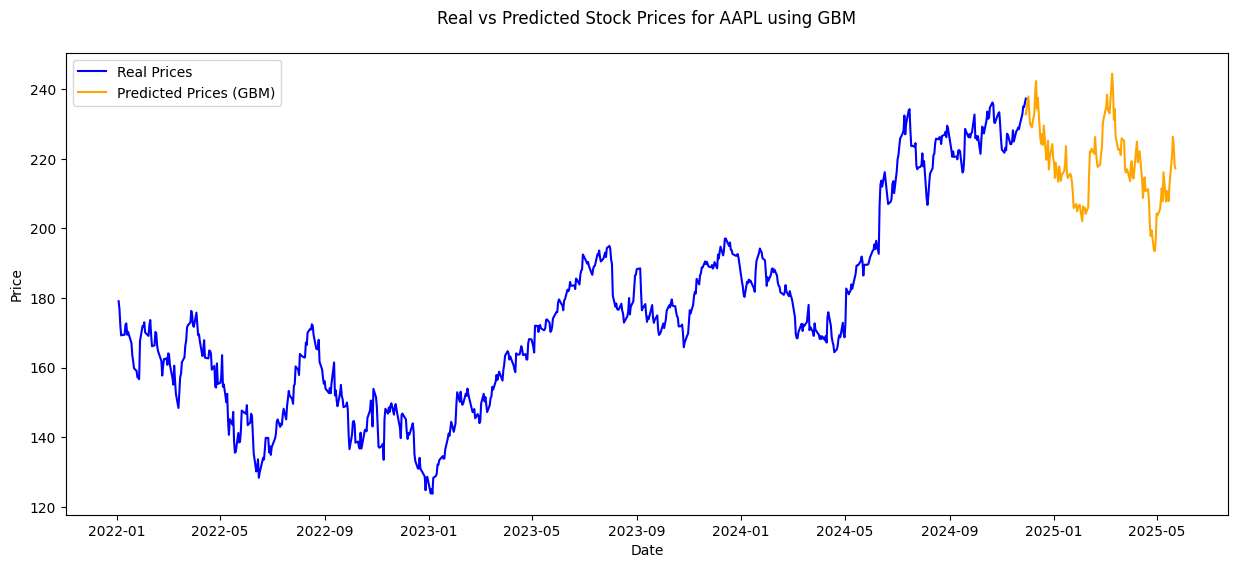

In [ ]:
# @title Updated Code for Any Ticker
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to calculate daily returns
def calculate_daily_returns(data, price_column):
    daily_returns = data[price_column].pct_change().dropna()
    return daily_returns

# GBM Function for a single path
def geometric_brownian_motion(S0, mu, sigma, T, dt, N):
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # Cumulative sum to get the Brownian motion path
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # GBM formula for a single path
    return S

# Fetch historical stock data
stock_ticker = 'AAPL'  # Change this to any ticker you want
data = yf.download(stock_ticker, start='2022-01-01', end='2024-11-30')

# Determine price column based on available data
if ('Adj Close', stock_ticker) in data.columns:
    price_column = ('Adj Close', stock_ticker)
else:
    price_column = ('Close', stock_ticker)

# Calculate daily returns and parameters for GBM
daily_returns = calculate_daily_returns(data, price_column)
mu = daily_returns.mean() * 252  # Mean return (annualized)
sigma = daily_returns.std() * np.sqrt(252)  # Volatility (annualized)
S0 = data[price_column].iloc[-1]  # Last closing price

# Parameters for the simulation
T = 6 / 12  # Time horizon (6 months)
dt = 1 / 252  # Daily steps (252 trading days in a year)
N = int(T / dt)  # Number of steps

# Generate the GBM simulation for a single path
predicted_prices = geometric_brownian_motion(S0, mu, sigma, T, dt, N)

# Create a future date index for the simulated prices
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=N, freq='B')  # B is for business days

# Create a DataFrame to hold real and predicted prices
predicted_data = pd.DataFrame(predicted_prices, index=future_dates, columns=['Predicted'])
real_and_predicted = pd.concat([data[price_column], predicted_data], axis=1)
real_and_predicted.columns = ['Real', 'Predicted']

# Calculate Mean Squared Error between the overlapping period
overlap_period = min(len(data), len(predicted_data))
mse = mean_squared_error(data[price_column][-overlap_period:], predicted_data['Predicted'][:overlap_period])

# Calculate historical and simulated drift and volatility
historical_drift = daily_returns.mean() * 252  # Annualized mean return
gbm_drift = mu - 0.5 * sigma**2  # GBM drift (annualized)
historical_volatility = daily_returns.std() * np.sqrt(252)  # Annualized historical volatility
predicted_returns = predicted_data['Predicted'].pct_change().dropna()  # Simulated returns
simulated_volatility = predicted_returns.std() * np.sqrt(252)  # Annualized simulated volatility

# Output the drifts and volatilities for comparison
print(f"Historical Drift (Annualized Mean Return): {historical_drift:.4f}")
print(f"GBM Drift (Expected Growth Rate): {gbm_drift:.4f}")
print(f"Historical Volatility: {historical_volatility:.4f}")
print(f"Simulated Volatility: {simulated_volatility:.4f}")

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(real_and_predicted.index, real_and_predicted['Real'], label='Real Prices', color='blue')  # Real Prices
plt.plot(predicted_data.index, predicted_data['Predicted'], label='Predicted Prices (GBM)', color='orange')  # Predicted Prices
plt.title(f'Real vs Predicted Stock Prices for {stock_ticker} using GBM\n')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# @title Interactive Graph
import plotly.graph_objects as go

fig = go.Figure()

# Real stock prices trace
fig.add_trace(go.Scatter(
    x=real_and_predicted.index,  # Date on x-axis
    y=real_and_predicted['Real'],  # Real prices on y-axis
    mode='lines+markers',
    name='Real Prices',
    marker=dict(
        symbol='circle',
        size=5,
        color='blue'
    ),
    line=dict(
        color='blue',
        width=2
    )
))

# Predicted stock prices trace
fig.add_trace(go.Scatter(
    x=predicted_data.index,  # Date on x-axis
    y=predicted_data['Predicted'],  # Predicted prices on y-axis
    mode='lines+markers',
    name='Predicted Prices',
    marker=dict(
        symbol='circle',
        size=5,
        color='orange'
    ),
    line=dict(
        color='orange',
        width=2
    )
))

# Template
fig.update_layout(
    title=f'Real vs Predicted Stock Prices for {stock_ticker} using GBM',  # Title
    xaxis_title='Date',  # x-axis label
    yaxis_title='Price',  # y-axis label
    xaxis_tickangle=-45,  # Tilt x-axis labels for better readability
    showlegend=True,  # Show the legend
    plot_bgcolor='#1e1e1e',  # Plot background to dark
    paper_bgcolor='#1e1e1e',  # Outside plot area background to dark
    font=dict(color='white'),  # Font color to white
    xaxis=dict(
        showgrid=True,  # Show grid lines x-axis
        gridcolor='gray',  # Grid line color
        color='white'  # Axis color white
    ),
    yaxis=dict(
        showgrid=True,  # Grid lines y-axis
        gridcolor='gray',  # Grid line color
        color='white'  # Axis color white
    )
)

fig.show()


[*********************100%***********************]  1 of 1 completed


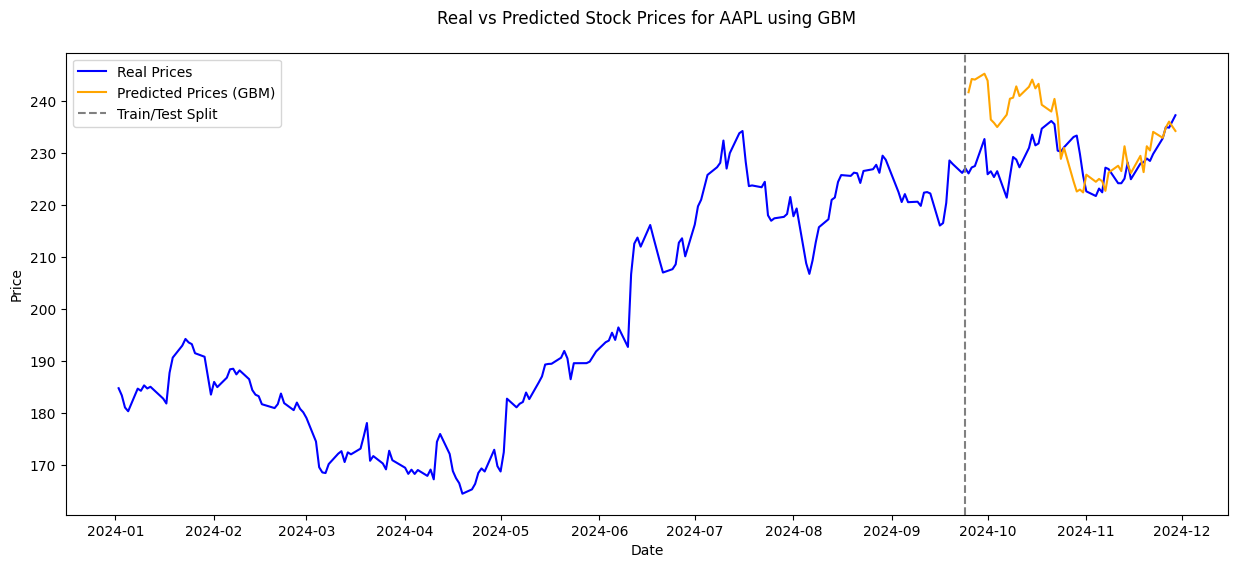

Mean Squared Error (MSE) on Test Data: 75.80


In [ ]:
# @title Train-Test
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Function to calculate daily returns
def calculate_daily_returns(data, price_column):
    daily_returns = data[price_column].pct_change().dropna()
    return daily_returns

# GBM Function for a single path
def geometric_brownian_motion(S0, mu, sigma, T, dt, N):
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # Cumulative sum to get the Brownian motion path
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # GBM formula for a single path
    return S

# Fetch historical stock data
stock_ticker = 'AAPL'
data = yf.download(stock_ticker, start='2024-01-01', end='2024-11-30')

# Determine price column based on available data
if ('Adj Close', stock_ticker) in data.columns:
    price_column = ('Adj Close', stock_ticker)
else:
    price_column = ('Close', stock_ticker)

prices = data[price_column]
# Split data into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(prices, test_size=0.2, shuffle=False)

# Calculate daily returns and parameters for GBM
daily_returns = calculate_daily_returns(data, price_column)
mu = daily_returns.mean() * 252  # Mean return (annualized)
sigma = daily_returns.std() * np.sqrt(252)  # Volatility (annualized)
S0 = data[price_column].iloc[-1]  # Last closing price

# Parameters for the simulation
T = len(test_data) / 252  # Time horizon based on the number of test days
dt = 1/252  # Daily steps (252 trading days in a year)
N = int(T / dt)  # Number of steps

# Generate the GBM simulation for a single path based on training data
predicted_prices = geometric_brownian_motion(S0, mu, sigma, T, dt, N)

# Create a future date index for the simulated prices
future_dates = test_data.index  # Use the same dates as the test data

# Create a DataFrame to hold real and predicted prices
predicted_data = pd.DataFrame(predicted_prices, index=future_dates, columns=['Predicted'])

# Calculate Mean Squared Error between actual test prices and predicted prices
mse = mean_squared_error(test_data, predicted_data['Predicted'])

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(prices.index, prices, label='Real Prices', color='blue')  # Real Prices
plt.plot(predicted_data.index, predicted_data['Predicted'], label='Predicted Prices (GBM)', color='orange')  # Predicted Prices
plt.axvline(x=train_data.index[-1], color='gray', linestyle='--', label='Train/Test Split')  # Mark train/test split
plt.title(f'Real vs Predicted Stock Prices for {stock_ticker} using GBM\n')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Output the Mean Squared Error
print(f'Mean Squared Error (MSE) on Test Data: {mse:.2f}')

In [ ]:
# @title Interactive graph for Train-Test
import plotly.graph_objects as go

# Interactive graph function
fig = go.Figure()

# Real stock prices trace
fig.add_trace(go.Scatter(
    x=prices.index,
    y=prices,
    mode='lines+markers',
    name='Real Prices',
    marker=dict(
        symbol='circle',
        size=5,
        color='blue'
    ),
    line=dict(
        color='blue',
        width=2
    )
))

# Predicted stock prices trace
fig.add_trace(go.Scatter(
    x=predicted_data.index,
    y=predicted_data['Predicted'],
    mode='lines+markers',
    name='Predicted Prices (GBM)',
    marker=dict(
        symbol='circle',
        size=5,
        color='orange'
    ),
    line=dict(
        color='orange',
        width=2
    )
))

# Train/Test Split Marker
fig.add_trace(go.Scatter(
    x=[train_data.index[-1], train_data.index[-1]],
    y=[prices.min(), prices.max()],
    mode='lines',
    name='Train/Test Split',
    line=dict(
        color='gray',
        dash='dash',
        width=2
    )
))

# Layout customization
fig.update_layout(
    title=f'Real vs Predicted Stock Prices for {stock_ticker} using GBM<br>MSE: {mse:.2f}',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_tickangle=-45,
    showlegend=True,
    plot_bgcolor='#1e1e1e',
    paper_bgcolor='#1e1e1e',
    font=dict(color='white'),
    xaxis=dict(
        showgrid=True,
        gridcolor='gray',
        color='white'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='gray',
        color='white'
    )
)

fig.show()
